In [1]:
from helpers import *

In [2]:
# Load datasets
df_articles, df_clicks, article_embeddings = load_dataset()

In [3]:
df_clicks

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,93863,1507865792177843,1507865792000,2,96210,1507865832925,4,3,2,1,21,2
1,93863,1507865792177843,1507865792000,2,158094,1507865862925,4,3,2,1,21,2
2,294036,1507865795185844,1507865795000,2,20691,1507865819095,4,3,20,1,9,2
3,294036,1507865795185844,1507865795000,2,96210,1507865849095,4,3,20,1,9,2
4,77136,1507865796257845,1507865796000,2,336245,1507866133178,4,3,2,1,25,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,15107,1507872960434128,1507872960000,4,20691,1507873325254,4,4,2,1,14,1
2988177,15107,1507872960434128,1507872960000,4,327984,1507873616575,4,4,2,1,14,1
2988178,15107,1507872960434128,1507872960000,4,172760,1507873646575,4,4,2,1,14,1
2988179,294270,1507872968214129,1507872968000,2,96210,1507873274995,4,3,2,1,25,2


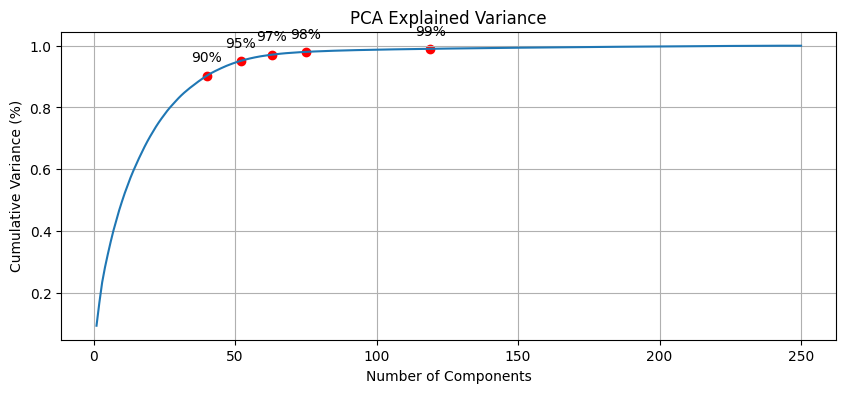

In [4]:
pca = PCA()
pca.fit(article_embeddings)

# Variance data
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
components = np.arange(len(cumulative_variance)) + 1

# Plotting
plt.figure(figsize=(10,4))
plt.plot(components, cumulative_variance, label='Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)')
plt.title('PCA Explained Variance')

# Annotate specific variance percentages
variance_thresholds = [0.9, 0.95, 0.97, 0.98, 0.99]
for threshold in variance_thresholds:
    component_number = np.where(cumulative_variance >= threshold)[0][0]
    plt.scatter(component_number + 1, cumulative_variance[component_number], color='red')
    plt.annotate(f"{int(threshold*100)}%", (component_number + 1, cumulative_variance[component_number]),
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.grid(True)
plt.show()

In [5]:
pca = PCA(n_components=0.98)
reduced_embeddings = pca.fit_transform(article_embeddings)
# reduced_embeddings = pca.fit_transform(article_embeddings)
print(reduced_embeddings.shape)
article_embeddings = reduced_embeddings
# cosine_sim_old = cosine_similarity(reduced_embeddings)


(364047, 75)


In [6]:
# preprocess data
df_articles = preprocessing_articles(df_articles)
df_clicks = preprocessing_clicks(df_clicks)
article_embeddings_df = pd.DataFrame(article_embeddings)
print("article_embeddings shape", article_embeddings_df.shape)
print("df_articles shape", df_articles.shape)

article_embeddings shape (364047, 75)
df_articles shape (364047, 5)


In [7]:
articles_clicked = df_clicks.click_article_id.value_counts().index
df_articles = df_articles.loc[articles_clicked]
article_embeddings_df = article_embeddings_df.loc[articles_clicked]

print("df_articles shape", df_articles.shape)
print("article_embeddings shape", article_embeddings_df.shape)

df_articles shape (46033, 5)
article_embeddings shape (46033, 75)


In [8]:
session_ids = df_clicks['session_id'].unique()
all_clicks_df = df_clicks[df_clicks['session_id'].isin(session_ids)]

df_clicks = df_clicks.sample(n=500000)

In [9]:
def train_test_split_sessions(clicks_df, test_size=0.1, val_size=0.1, random_state=42):
    session_ids = clicks_df['session_id'].unique()
    train_sessions, test_sessions = train_test_split(session_ids, test_size=test_size, random_state=random_state)
    train_sessions, val_sessions = train_test_split(train_sessions, test_size=val_size, random_state=random_state)
    
    train_df = clicks_df[clicks_df['session_id'].isin(train_sessions)]
    val_df = clicks_df[clicks_df['session_id'].isin(val_sessions)]
    test_df = clicks_df[clicks_df['session_id'].isin(test_sessions)]
    all_df = clicks_df[clicks_df['session_id'].isin(session_ids)]
    
    return train_df, val_df, test_df
 

# Split the clicks dataframe
train_clicks_df, val_clicks_df, test_clicks_df = train_test_split_sessions(df_clicks)

print(f"Training clicks shape: {train_clicks_df.shape}")
print(f"Validation clicks shape: {val_clicks_df.shape}")
print(f"Testing clicks shape: {test_clicks_df.shape}")
print(f"All clicks shape: {all_clicks_df.shape}")

Training clicks shape: (405148, 14)
Validation clicks shape: (44722, 14)
Testing clicks shape: (50130, 14)
All clicks shape: (2988181, 14)


In [10]:
#### Merging Articles Embeddings with Articles Metadata

# Merging with articles_metadata
# articles_merged_df = pd.merge(df_articles, article_embeddings_df, on='article_id')

In [11]:
tqdm.pandas()

def create_user_profiles(clicks_df, article_embeddings_df):
    user_profiles = clicks_df.groupby('user_id')['click_article_id'].apply(list).reset_index()
    embeddings_dict = article_embeddings_df.T.to_dict('list')
    
    user_profiles['user_embedding'] = user_profiles['click_article_id'].progress_apply(
        lambda x: np.mean([embeddings_dict[article] for article in x if article in embeddings_dict], axis=0)
    )
    
    return user_profiles

user_profiles_df_train = create_user_profiles(train_clicks_df, article_embeddings_df)
user_profiles_df_test = create_user_profiles(test_clicks_df, article_embeddings_df)
user_profiles_df_val = create_user_profiles(val_clicks_df, article_embeddings_df)
user_profiles_df_all = create_user_profiles(all_clicks_df, article_embeddings_df)

100%|██████████| 322897/322897 [00:07<00:00, 40563.99it/s]


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def create_content_based_model(input_dim):
    model = models.Sequential()
    # Input Layer
    model.add(layers.Input(shape=(input_dim,)))
    
    # Hidden Layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    
    # Output Layer - Predicting the relevance score
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[ndcg_5, ndcg_10, mean_mrr, g_auc])
    return model

In [13]:
# Prepare data
def prepare_data(user_profiles_df_train, articles_df, articles_embeddings_df):
    X = []
    y = []
    
    embeddings_dict = articles_embeddings_df.T.to_dict('list')
    
    for i, user in tqdm(user_profiles_df_train.iterrows(), total=len(user_profiles_df_train)):
        # if i >= 50000:
        #     break
        
        user_embedding = user['user_embedding']
        clicked_articles = user['click_article_id']
        
        for article_id in clicked_articles:
            if article_id in embeddings_dict:
                article_embedding = embeddings_dict[article_id]
                combined_features = np.concatenate((user_embedding, article_embedding))
                X.append(combined_features)
                y.append(1) # Positive sample
        
        # Add some negative samples for training
        negative_samples = articles_df[~articles_df['article_id'].isin(clicked_articles)]['article_id'].sample(n=len(clicked_articles))
        
        for article_id in negative_samples:
            if article_id in embeddings_dict:
                article_embedding = embeddings_dict[article_id]
                combined_features = np.concatenate((user_embedding, article_embedding))
                X.append(combined_features)
                y.append(0) # Negative sample
                
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [14]:
X_train, y_train = prepare_data(user_profiles_df_train, df_articles, article_embeddings_df)


100%|██████████| 170671/170671 [03:46<00:00, 754.72it/s]


In [15]:
X_val, y_val = prepare_data(user_profiles_df_val, df_articles, article_embeddings_df)


100%|██████████| 32295/32295 [00:41<00:00, 776.28it/s]


In [16]:
def mrr(labels, predictions):
    if len(labels) != len(predictions):
        raise ValueError("Length of labels and predictions must be equal")

    # Combine labels and predictions, then sort by prediction score in descending order
    combined = list(zip(labels, predictions))
    combined_sorted = sorted(combined, key=lambda x: x[1], reverse=True)

    # Identify the rank position of the first relevant item (label == 1)
    for idx, (label, _) in enumerate(combined_sorted):
        if label == 1:
            return 1.0 / (idx + 1)

    # If no relevant item is found, return 0
    return 0.0

In [17]:
# Assuming article_embeddings's second dimension size is 250
input_dim = X_train.shape[1]
content_based_model = create_content_based_model(input_dim)

content_based_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               19328     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 27649 (108.00 KB)
Trainable params: 27649 (108.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
X_train

array([[ 2.2112751 , -0.30801758, -1.80026197, ..., -0.03572226,
         0.13493477,  0.01883112],
       [ 2.2112751 , -0.30801758, -1.80026197, ...,  0.02933148,
         0.10656763,  0.01003804],
       [-1.06399345, -0.88186461,  0.70313138, ..., -0.21020693,
         0.03184228,  0.22681524],
       ...,
       [ 2.88039351,  2.49042153, -1.68514574, ...,  0.10053461,
         0.1648214 , -0.38228804],
       [-2.08881927, -2.2395978 , -0.09488426, ..., -0.0029037 ,
         0.03311857,  0.0289492 ],
       [-2.08881927, -2.2395978 , -0.09488426, ..., -0.20279914,
         0.13396192,  0.23437645]])

In [19]:
class CustomMetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"\n\nEpoch {epoch+1}:", end=" ")
        for key, value in logs.items():
            print(f"\n- {key}: {value:.4f}", end=", ")
        print("\n")

# Using the custom callback
custom_metrics_callback = CustomMetricsCallback()
# Train the model
history = content_based_model.fit(
    X_train, 
    y_train, 
    epochs=10, 
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[custom_metrics_callback]
)

Epoch 1/10
25283/25322 [============================>.] - ETA: 0s - loss: 0.1540 - ndcg_5: 0.5027 - ndcg_10: 0.5027 - mean_mrr: 0.0638 - g_auc: 0.9834

Epoch 1: 
- loss: 0.1540, 
- ndcg_5: 0.5027, 
- ndcg_10: 0.5027, 
- mean_mrr: 0.0638, 
- g_auc: 0.9835, 
- val_loss: 0.0262, 
- val_ndcg_5: 0.7772, 
- val_ndcg_10: 0.7772, 
- val_mean_mrr: 0.0987, 
- val_g_auc: 0.9992, 

25322/25322 [==============================] - 34s 1ms/step - loss: 0.1540 - ndcg_5: 0.5027 - ndcg_10: 0.5027 - mean_mrr: 0.0638 - g_auc: 0.9835 - val_loss: 0.0262 - val_ndcg_5: 0.7772 - val_ndcg_10: 0.7772 - val_mean_mrr: 0.0987 - val_g_auc: 0.9992
Epoch 2/10
25308/25322 [============================>.] - ETA: 0s - loss: 0.1081 - ndcg_5: 0.4969 - ndcg_10: 0.4969 - mean_mrr: 0.0630 - g_auc: 0.9928

Epoch 2: 
- loss: 0.1081, 
- ndcg_5: 0.4969, 
- ndcg_10: 0.4969, 
- mean_mrr: 0.0630, 
- g_auc: 0.9928, 
- val_loss: 0.0232, 
- val_ndcg_5: 0.7772, 
- val_ndcg_10: 0.7772, 
- val_mean_mrr: 0.0987, 
- val_g_auc: 0.9994, 

2532

In [20]:
embeddings_dict = article_embeddings_df.T.to_dict('list')
model = content_based_model
articles_df = df_articles

# List to store evaluation metrics
precisions, recalls, mrrs, ndcgs = [], [], [], []

all_true_labels = []
all_scores = []

In [21]:
from joblib import Parallel, delayed
import numpy as np
from sklearn.metrics import roc_auc_score

from concurrent.futures import ThreadPoolExecutor

def process_user_wrapper(args):
    return process_user(*args)

def process_user(user, k):
    user_embedding = user['user_embedding']
    user_id = user['user_id']
    clicked_articles = set(user['click_article_id'])

    all_embeddings = []
    article_ids = [article_id for article_id in articles_df['article_id'] if article_id in embeddings_dict]
    all_embeddings = [np.concatenate((user_embedding, embeddings_dict[article_id])).reshape(1, -1) for article_id in article_ids]
    
    all_embeddings = np.vstack(all_embeddings)
    
    scores = model.predict(all_embeddings, verbose=0).flatten()
    
    true_labels = np.array([1 if article_id in clicked_articles else 0 for article_id in article_ids])

    precisions.append(precision_at_k(true_labels, scores, k))
    recalls.append(recall_at_k(true_labels, scores, k))
    mrrs.append(mrr(true_labels, scores))
    ndcgs.append(ndcg_at_k(true_labels, scores, k))
    
    all_true_labels.extend(true_labels)
    all_scores.extend(scores)
    
def evaluate_model_optimized(model, user_profiles_df_train, articles_df, articles_embeddings_df, k=10, num_users=2000):
    # sampled_user_profiles_df = user_profiles_df_train.sample(n=num_users, random_state=42)
    
    sampled_user_profiles_df = user_profiles_df_train[user_profiles_df_train["user_id"] == 15958]

    for _, user in tqdm(sampled_user_profiles_df.iterrows(), total=num_users, desc="Evaluating", ncols=100):
        process_user(user, k)

    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_mrr = np.mean(mrrs)
    avg_ndcg = np.mean(ndcgs)
    g_auc = roc_auc_score(all_true_labels, all_scores)

    return avg_ndcg, avg_mrr, avg_precision, avg_recall, g_auc

In [22]:
user_profiles_df_test.shape

(35338, 3)

In [23]:
%%time
# ndcg_score, mrr_score, auc_score, y_pred = evaluate_model_on_test_data(content_based_model, X_test, y_test)
# print(f"NDCG@10: {ndcg_score:.4f}, MRR: {mrr_score:.4f}, AUC: {auc_score:.4f}")
# Evaluation
# ndcg_score, mrr_score, g_auc_score, y_true, y_pred, user_ids = evaluate_model_optimized(content_based_model, user_profiles_df_test, df_articles, article_embeddings_df, k=10, num_users=len(user_profiles_df_test))
avg_ndcg, avg_mrr, avg_precision, avg_recall, g_auc = evaluate_model_optimized(content_based_model, user_profiles_df_test, df_articles, article_embeddings_df, k=10, num_users=1)
print(f"NDCG@10: {avg_ndcg:.4f}, MRR: {avg_mrr:.4f}, precision: {avg_precision:.4f}, recall: {avg_recall:.4f}")


Evaluating: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]

NDCG@10: 1.0000, MRR: 1.0000, precision: 0.1000, recall: 1.0000
CPU times: user 793 ms, sys: 84.8 ms, total: 878 ms
Wall time: 784 ms


In [24]:
def infer_top_k_articles(user_id, user_profiles_df, df_articles, article_embeddings_df, model, k=5):
    tmp_df_articles = df_articles.copy()
    # Retrieve the user's embedding
    user_profile = user_profiles_df[user_profiles_df['user_id'] == user_id].iloc[0]
    
    if user_profile.empty:
        raise ValueError("User ID not found in the user profiles.")

    user_embedding = user_profile['user_embedding']

    # Get all articles embeddings
    embeddings_dict = article_embeddings_df.T.to_dict('list')
    
    article_ids = []
    combined_features_list = []
    
    for article_id, article_embedding in embeddings_dict.items():
        article_ids.append(article_id)
        combined_features = np.concatenate((user_embedding, article_embedding)).reshape(1, -1)
        combined_features_list.append(combined_features)

    all_embeddings = np.vstack(combined_features_list)
    
    # Predict relevance scores using the trained model
    scores = model.predict(all_embeddings, verbose=0).flatten()

    print(user_profile["click_article_id"])
    # Add scores to dataframe
    tmp_df_articles['score'] = tmp_df_articles['article_id'].map(dict(zip(article_ids, scores)))
    tmp_df_articles = tmp_df_articles.sort_values(by='score', ascending=False)

    top_articles = tmp_df_articles.copy()[["article_id","category_id","score"]]
    user_article_clicked = top_articles[top_articles['article_id'].isin(user_profile["click_article_id"])].reset_index(drop=True)

    top_articles = top_articles[~top_articles['article_id'].isin(user_profile["click_article_id"])]

    # Rank articles based on scores
    top_k_indices = np.argsort(scores)[-k:][::-1]
    top_k_article_ids = [article_ids[i] for i in top_k_indices]
    
    # Rank articles based on scores (worst)
    bottom_k_indices = np.argsort(scores)[:k]
    bottom_k_article_ids = [article_ids[i] for i in bottom_k_indices]

    # Fetch top K articles metadata
    top_k_articles = top_articles[top_articles['article_id'].isin(top_k_article_ids)].reset_index(drop=True)
    bottom_k_article_ids = top_articles[top_articles['article_id'].isin(bottom_k_article_ids)].reset_index(drop=True)
    bottom_k_article_ids = bottom_k_article_ids.sort_values(by='score', ascending=True)
    
    # Display the top K articles usi
    return top_k_articles, bottom_k_article_ids, user_article_clicked

In [26]:
import numpy as np
from sklearn.metrics import roc_auc_score

def compute_dcg(y_true, y_pred, k):
    order = np.argsort(y_pred)[::-1]
    y_true = np.take(y_true, order[:k])
    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(1, len(y_true) + 1) + 1)
    return np.sum(gains / discounts)

def compute_ndcg(y_true, y_pred, k):
    if len(np.unique(y_true)) < 2:
        return 0.0
    dcg = compute_dcg(y_true, y_pred, k)
    idcg = compute_dcg(y_true, sorted(y_true, reverse=True), k)
    return dcg / idcg if idcg > 0 else 0.0

def show_ndcg_for_user(user_id, k=10):
    user = sampled_user_profiles_df.loc[sampled_user_profiles_df['user_id'] == user_id].iloc[0]
    user_embedding = user['user_embedding']
    clicked_articles = set(user['click_article_id'])

    all_embeddings = []
    article_ids = [article_id for article_id in articles_df['article_id'] if article_id in embeddings_dict]
    all_embeddings = [np.concatenate((user_embedding, embeddings_dict[article_id])).reshape(1, -1) for article_id in article_ids]
    
    all_embeddings = np.vstack(all_embeddings)
    
    scores = model.predict(all_embeddings, verbose=0).flatten()
    
    true_labels = np.array([1 if article_id in clicked_articles else 0 for article_id in article_ids])
    
    order = np.argsort(scores)[::-1][:k]
    ranked_article_ids = np.array(article_ids)[order]
    ranked_scores = scores[order]
    ranked_true_labels = true_labels[order]
      
    ndcg_score = compute_ndcg(ranked_true_labels, ranked_scores, k)
    
    print(f"User ID: {user_id}")
    
    print("\nGround Truth Relevance:")
    for article_id, label in zip(article_ids, true_labels):
        if label > 0:
            print(f"  Article {article_id}: Relevance {label}")
    
    print("\nTop-{0} Predicted Ranking:".format(k))
    for i, (article_id, score, true_label) in enumerate(zip(ranked_article_ids, ranked_scores, ranked_true_labels)):
        print(f"  Rank {i+1}: Article {article_id} | Predicted Score: {score:.4f} | True Relevance: {true_label}")
    
    print(f"\nNDCG@{k}: {ndcg_score:.4f}")

# Example usage:
sampled_user_profiles_df = user_profiles_df_test.sample(n=100, random_state=42)
# evaluate_model_optimized(model, user_profiles_df_train, articles_df, articles_embeddings_df, k=10, num_users=2000)
# Replace 'sample_user_id' with an actual user ID from your dataset
# sampled_user_profiles_df
show_ndcg_for_user(15958, k=10)

IndexError: single positional indexer is out-of-bounds

In [27]:
def show_detailed_ndcg_for_user(user_id, k=10):
    user = sampled_user_profiles_df.loc[sampled_user_profiles_df['user_id'] == user_id].iloc[0]
    user_embedding = user['user_embedding']
    clicked_articles = set(user['click_article_id'])

    all_embeddings = []
    article_ids = [article_id for article_id in articles_df['article_id'] if article_id in embeddings_dict]
    all_embeddings = [np.concatenate((user_embedding, embeddings_dict[article_id])).reshape(1, -1) for article_id in article_ids]
    
    all_embeddings = np.vstack(all_embeddings)
    
    scores = model.predict(all_embeddings, verbose=0).flatten()
    
    true_labels = np.array([1 if article_id in clicked_articles else 0 for article_id in article_ids])
    
    order = np.argsort(scores)[::-1][:k]
    ranked_article_ids = np.array(article_ids)[order]
    ranked_scores = scores[order]
    ranked_true_labels = true_labels[order]
    
    dcg_score = compute_dcg(ranked_true_labels, ranked_scores, k)
    idcg_score = compute_dcg(ranked_true_labels, sorted(ranked_true_labels, reverse=True), k)
    ndcg_score = dcg_score / idcg_score if idcg_score > 0 else 0.0
    
    print(f"User ID: {user_id}")

    print("\nGround Truth Relevance:")
    for article_id, label in zip(article_ids, true_labels):
        if label > 0:
            print(f"  Article {article_id}: Relevance {label}")
    
    print("\nTop-{0} Predicted Ranking:".format(k))
    for i, (article_id, score, true_label) in enumerate(zip(ranked_article_ids, ranked_scores, ranked_true_labels)):
        print(f"  Rank {i+1}: Article {article_id} | Predicted Score: {score:.4f} | True Relevance: {true_label}")
    
    print(f"\nDCG@{k}: {dcg_score:.4f}")
    print(f"IDCG@{k}: {idcg_score:.4f}")
    print(f"NDCG@{k}: {ndcg_score:.4f}")
show_detailed_ndcg_for_user(15958, k=10)

IndexError: single positional indexer is out-of-bounds

In [28]:
def show_detailed_ndcg_for_user(user_id, k=10):
    user = sampled_user_profiles_df.loc[sampled_user_profiles_df['user_id'] == user_id].iloc[0]
    user_embedding = user['user_embedding']
    clicked_articles = set(user['click_article_id'])

    all_embeddings = []
    article_ids = [article_id for article_id in articles_df['article_id'] if article_id in embeddings_dict]
    all_embeddings = [np.concatenate((user_embedding, embeddings_dict[article_id])).reshape(1, -1) for article_id in article_ids]
    
    all_embeddings = np.vstack(all_embeddings)
    
    scores = model.predict(all_embeddings, verbose=0).flatten()
    
    true_labels = np.array([1 if article_id in clicked_articles else 0 for article_id in article_ids])
    
    order = np.argsort(scores)[::-1][:k]
    ranked_article_ids = np.array(article_ids)[order]
    ranked_scores = scores[order]
    ranked_true_labels = true_labels[order]
    
    dcg_score = compute_dcg(ranked_true_labels, ranked_scores, k)
    idcg_score = compute_dcg(ranked_true_labels, sorted(ranked_true_labels, reverse=True), k)
    ndcg_score = dcg_score / idcg_score if idcg_score > 0 else 0.0
    
    print(f"User ID: {user_id}")

    print("\nGround Truth Relevance:")
    for article_id, label in zip(article_ids, true_labels):
        if label > 0:
            print(f"  Article {article_id}: Relevance {label}")
    
    print("\nTop-{0} Predicted Ranking:".format(k))
    for i, (article_id, score, true_label) in enumerate(zip(ranked_article_ids, ranked_scores, ranked_true_labels)):
        print(f"  Rank {i+1}: Article {article_id} | Predicted Score: {score:.4f} | True Relevance: {true_label}")
    
    print(f"\nDCG@{k}: {dcg_score:.4f}")
    print(f"IDCG@{k}: {idcg_score:.4f}")
    print(f"NDCG@{k}: {ndcg_score:.4f}")
show_detailed_ndcg_for_user(15958, k=10)

IndexError: single positional indexer is out-of-bounds

In [ ]:
show_ndcg_for_user(15958, k=10)

In [ ]:
user_profiles_df_train

In [ ]:
user_id=3
user_id=15958
top_k_articles, bottom_k_article_ids, user_article_clicked = infer_top_k_articles(user_id, user_profiles_df_all, df_articles, article_embeddings_df, content_based_model, k=50)

In [ ]:
user_article_clicked

In [ ]:
top_k_articles[top_k_articles["article_id"].isin(user_article_clicked["article_id"])]

In [ ]:
top_k_articles

In [ ]:
bottom_k_article_ids

In [30]:
content_based_model.save('./input/content-based-reduced.h5')

/Users/m/dev/6be709c0/oc-ai-engineer/OC/P10/venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

user_profiles_df_test.to_pickle("./input/user_profiles_df_test-reduced.pkl")

In [31]:
with open('./input/embeddings_dict.pkl', 'wb') as f:
    pickle.dump(embeddings_dict, f)

In [33]:
# Save DataFrames to disk
user_profiles_df_all.to_pickle("./input/user_profiles_df_all-reduced.pkl")
df_articles.to_pickle("./input/df_articles-reduced.pkl")
article_embeddings_df.to_pickle("./input/article_embeddings_df-reduced.pkl")

In [ ]:
article_embeddings_df.shape

In [ ]:
def infer_all_articles_scores(user_id, df, df_articles, article_embeddings_df, model):
    # Retrieve the user's embedding
    user_profile = df[df['user_id'] == user_id].iloc[0]
    
    if user_profile.empty:
        raise ValueError("User ID not found in the user profiles.")

    user_embedding = user_profile['user_embedding']

    # Get all articles embeddings
    embeddings_dict = article_embeddings_df.T.to_dict('list')
    
    article_ids = list(embeddings_dict.keys())
    combined_features_list = [np.concatenate((user_embedding, article_embedding)).reshape(1, -1) 
                              for article_embedding in embeddings_dict.values()]

    all_embeddings = np.vstack(combined_features_list)
    
    # Predict relevance scores using the trained model
    scores = model.predict(all_embeddings, verbose=0).flatten()

    # Create a dataframe with article IDs, category IDs, and scores
    article_scores_df = df_articles[['article_id', 'category_id']].copy()
    article_scores_df['score'] = article_scores_df['article_id'].map(dict(zip(article_ids, scores)))
    
    # Remove any unwanted header rows if present
    # article_scores_df.columns = article_scores_df.columns.droplevel(0)
    article_scores_df.reset_index(drop=True, inplace=True)
    return article_scores_df

In [ ]:
articles_scores = infer_all_articles_scores(user_id, user_profiles_df_all, df_articles, article_embeddings_df, content_based_model)
articles_scores